[Source](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html)

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('../tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/eardil/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eardil/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eardil/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eardil/.pyenv/versions/3.6.1/lib/python3

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Create a predict fn for inception v3, takes in a list of images and returns a matrix of prediction probabilities

In [2]:
from nets import inception
from preprocessing import inception_preprocessing

In [3]:
session = tf.Session()

In [14]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f, 'rb').read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [5]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [6]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [7]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '../tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../tf-models/slim/pretrained/inception_v3.ckpt


In [8]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

## Imagen particular

8 cock 0.03350348
107 wombat 0.058830444
9 hen 0.058996134
337 marmot 0.11672203
338 beaver 0.18447275


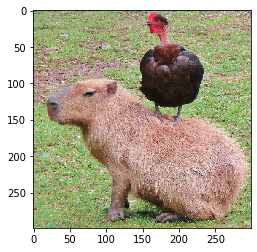

In [36]:
images = transform_img_fn(['/home/eardil/Downloads/capy.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

In [37]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [38]:
image = images[0]
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

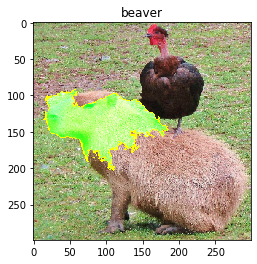

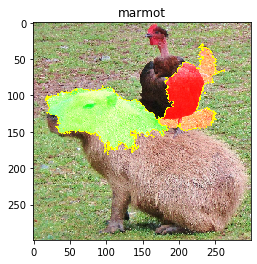

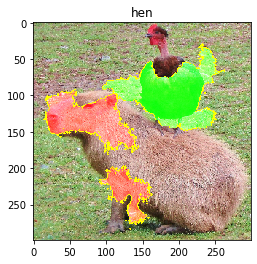

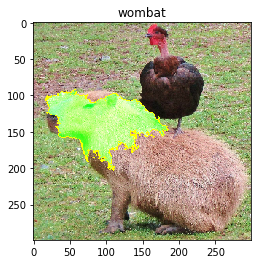

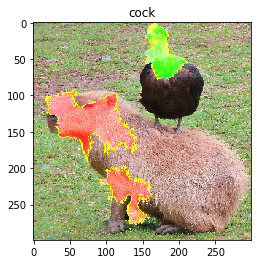

In [39]:
for lab in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(lab, positive_only=False, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(names[lab])
    plt.show()